In [1]:
from utils import *
from models import *
from loss import *
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import colors
from datetime import datetime

In [ ]:
train_path = './next_day_fires/next_day_wildfire_spread_train*'
val_path = './next_day_fires/next_day_wildfire_spread_eval*'
test_path = './next_day_fires/next_day_wildfire_spread_test*'
features = ['elevation', 'th', 'vs',  'tmmn', 'tmmx', 'sph', 'pr', 'pdsi', 'NDVI', 'population', 'erc', 'PrevFireMask', 'FireMask']

# Load Data

## Training Data

In [3]:
train_dataset = get_dataset(
      train_path,
      data_size=64,
      sample_size=64,
      batch_size=100,
      num_in_channels=12,
      compression_type=None,
      clip_and_normalize=False,
      clip_and_rescale=False,
      random_crop=True,
      center_crop=False)

train_inputs, train_labels = next(iter(train_dataset))

print(train_inputs.shape)
print(train_labels.shape)

torch.Size([100, 12, 64, 64])
torch.Size([100, 1, 64, 64])


In [4]:
titles = [
  'Elevation',
  'Wind\ndirection',
  'Wind\nvelocity',
  'Min\ntemp',
  'Max\ntemp',
  'Humidity',
  'Precip',
  'Drought',
  'Vegetation',
  'Population\ndensity',
  'Energy\nrelease\ncomponent',
  'Previous\nfire\nmask',
  'Fire\nmask'
]

n_rows = 5
n_features = train_inputs.shape[3] 
CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
BOUNDS = [-1, -0.1, 0.001, 1]
NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)
keys = ['elevation', 'th', 'vs',  'tmmn', 'tmmx', 'sph', 'pr', 'pdsi', 'NDVI', 'population', 'erc', 'PrevFireMask']

In [5]:
# fig = plt.figure(figsize=(20,8))

# for i in range(n_rows):
#   for j in range(n_features + 1):
#     plt.subplot(n_rows, n_features + 1, i * (n_features + 1) + j + 1)
#     if i == 0:
#       plt.title(titles[j], fontsize=15)
#     if j < n_features - 1:
#       plt.imshow(train_inputs[i, j, :, :], cmap='viridis')
#     if j == n_features - 1:
#       plt.imshow(train_inputs[i, -1, :, :], cmap=CMAP, norm=NORM)
#     if j == n_features:
#       plt.imshow(train_labels[i, 0, :, :], cmap=CMAP, norm=NORM) 
#     plt.axis('off')
# plt.tight_layout()

## Vlidation Data

In [6]:
val_dataset = get_dataset(
      val_path,
      data_size=64,
      sample_size=64,
      batch_size=100,
      num_in_channels=12,
      compression_type=None,
      clip_and_normalize=False,
      clip_and_rescale=False,
      random_crop=True,
      center_crop=False)

val_inputs, val_labels = next(iter(val_dataset))

print(val_inputs.shape)
print(val_labels.shape)

torch.Size([100, 12, 64, 64])
torch.Size([100, 1, 64, 64])


## Test Data

In [7]:
test_dataset = get_dataset(
      test_path,
      data_size=64,
      sample_size=64,
      batch_size=100,
      num_in_channels=12,
      compression_type=None,
      clip_and_normalize=False,
      clip_and_rescale=False,
      random_crop=True,
      center_crop=False)

test_inputs, test_labels = next(iter(val_dataset))

print(test_inputs.shape)
print(test_labels.shape)

torch.Size([100, 12, 64, 64])
torch.Size([100, 1, 64, 64])


In [8]:
# Build DataLoader
train_loader = DataLoader(train_dataset, batch_size=None, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=None, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=None, num_workers=0, pin_memory=True)

# Model Initialization

In [9]:
folder_path = './gen_models'
gen_input_channels = 12
disc_input_channels = 13
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Hyperparameters

In [10]:
#  Hyperparameters
kernel_size = 4 # DO NOT CHANGE
stride = 2 # DO NOT CHANGE
padding = 1 # DO NOT CHANGE
dropout = 0.5

gen_lr = 1e-4
disc_lr = 1e-4

alpha = 1
lambd = 50
pos_weight = 40 # Was 30
bce_weight = 0.5

num_epochs = 500
patience = 70

### Model Initialization

In [11]:
generator = Generator(gen_input_channels, kernel_size, stride, padding, dropout)
discriminator = Discriminator(disc_input_channels, kernel_size, stride, padding)

generator.apply(init_weights)
discriminator.apply(init_weights)

generator.to(device)
discriminator.to(device)

Discriminator(
  (e1): Conv2d(13, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (lr1): LeakyReLU(negative_slope=0.2)
  (e2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (eb2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lr2): LeakyReLU(negative_slope=0.2)
  (output): Conv2d(128, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
)

# Model Testing

In [12]:
generator.load_state_dict(torch.load("./gen_models/best_model_61.26020511827971_20250428_130947.pth", map_location=device))
generator.eval()

# Arrays to store all predictions and all ground truth masks
pred_mask_all, target_all = [], []

with torch.no_grad():
    for batch in test_loader:
        images, target = batch
        images = images.to(device)
        target = target.to(device)

        # Make test predictions
        pred_mask = generator(images)

        pred_mask_all.append(pred_mask.cpu().numpy())
        target_all.append(target.cpu().numpy())

    # Concatenate all batches into a single array for performance                        
    preds = np.concatenate(pred_mask_all, axis=0)   
    trues = np.concatenate(target_all, axis=0)        

    # Squeeze from 4 dimensions into 3 since we use only one channel
    if preds.ndim == 4 and preds.shape[1] == 1:
        preds = preds.squeeze(1)
        trues = trues.squeeze(1)

    # Binarize predictions
    preds  = (preds > 0.5).astype(np.uint8)
    trues  = trues.astype(np.uint8)

    preds = preds.flatten()
    trues = trues.flatten()

    # Calculate TP, FP, FN for evaluation metrics
    tp = np.logical_and(preds==1, trues==1).sum()
    fp = np.logical_and(preds==1, trues==0).sum()
    fn = np.logical_and(preds==0, trues==1).sum()

    # Calculate evaluation metrics
    smooth = 1e-6
    dice = (2*tp + smooth) / (2*tp + fp + fn + smooth)
    iou  = (tp + smooth)   / (tp + fp + fn + smooth)
    recall = tp / (tp + fn + smooth)

                             
    # Dice coefficient
    # IoU (Jaccard Index)
    # Recall - We care a lot about false negatives
    metrics = {
        'Dice Coefficient': dice,
        'IoU': iou,
        'Recall': recall
        }
    
    print("\n **Test Results:**")
    for key, value in metrics.items():
        print(f"{key}: {value:.4f}")


 **Test Results:**
Dice Coefficient: 0.2752
IoU: 0.1596
Recall: 0.3824


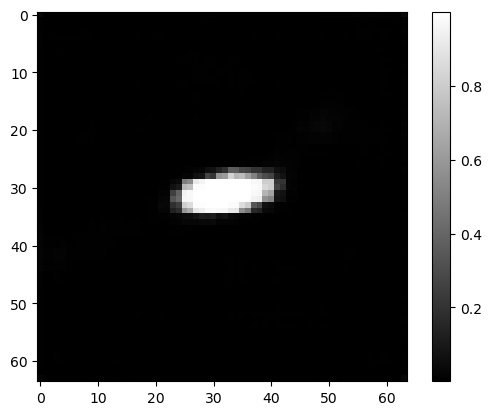

array([[0.03177339, 0.00604566, 0.00720854, ..., 0.00974786, 0.00681056,
        0.0365565 ],
       [0.00663226, 0.00036681, 0.00054417, ..., 0.0007564 , 0.0009391 ,
        0.00848922],
       [0.00521811, 0.00046741, 0.00076646, ..., 0.00105906, 0.00082375,
        0.00507769],
       ...,
       [0.00568661, 0.0006929 , 0.00052616, ..., 0.00045776, 0.00040106,
        0.00504436],
       [0.00369354, 0.00055014, 0.00062217, ..., 0.00058576, 0.00043502,
        0.00414131],
       [0.02698011, 0.00432965, 0.00473498, ..., 0.00362379, 0.00349556,
        0.03156319]], dtype=float32)

In [15]:
img, lab = next(iter(test_loader))
pred = generator(img.to(device))
tensor_np = pred[20][0].detach().cpu().numpy()
#tensor_np = pred[22][0]

#tensor_np = (tensor_np > 0.5).astype(int)
plt.imshow(tensor_np, cmap='gray')
plt.colorbar()
plt.show()
tensor_np

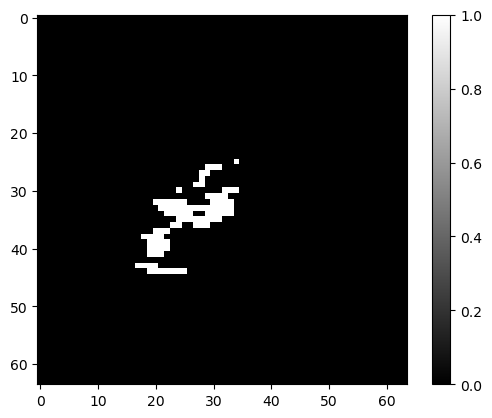

In [16]:
tensor_np = lab[20][0].detach().cpu().numpy()

plt.imshow(tensor_np, cmap='gray')
plt.colorbar()
plt.show()

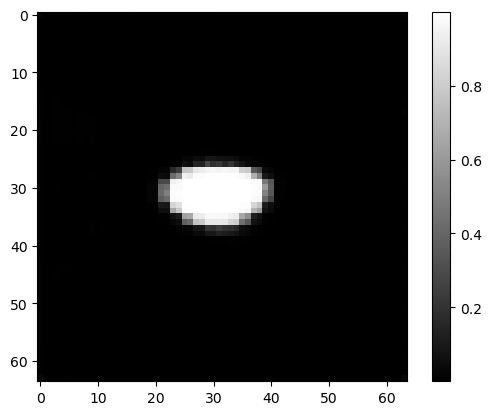

array([[2.4980813e-02, 3.6845412e-03, 3.8969580e-03, ..., 2.5495514e-03,
        2.3045430e-03, 2.2713099e-02],
       [3.1135592e-03, 9.0259215e-05, 1.2534409e-04, ..., 4.0111441e-05,
        5.0324805e-05, 2.9663285e-03],
       [2.2754062e-03, 9.5062089e-05, 1.5427302e-04, ..., 4.5760284e-05,
        4.7061138e-05, 1.3476061e-03],
       ...,
       [6.3640648e-03, 5.4228783e-04, 3.6003016e-04, ..., 1.7586493e-04,
        1.6727031e-04, 4.4944352e-03],
       [4.9619153e-03, 5.5162073e-04, 5.1178614e-04, ..., 2.3885326e-04,
        1.7542881e-04, 3.6409500e-03],
       [3.3617999e-02, 5.3282944e-03, 5.0049215e-03, ..., 3.2797656e-03,
        2.8491819e-03, 3.2711934e-02]], dtype=float32)

In [17]:
tensor_np = pred[2][0].detach().cpu().numpy()
#tensor_np = pred[22][0]

#tensor_np = (tensor_np > 0.5).astype(int)
plt.imshow(tensor_np, cmap='gray')
plt.colorbar()
plt.show()
tensor_np

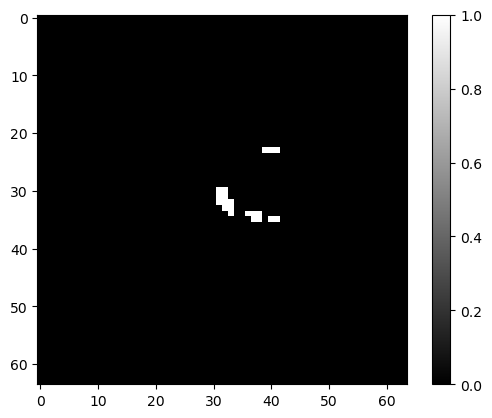

In [18]:
tensor_np = lab[2][0].detach().cpu().numpy()

plt.imshow(tensor_np, cmap='gray')
plt.colorbar()
plt.show()

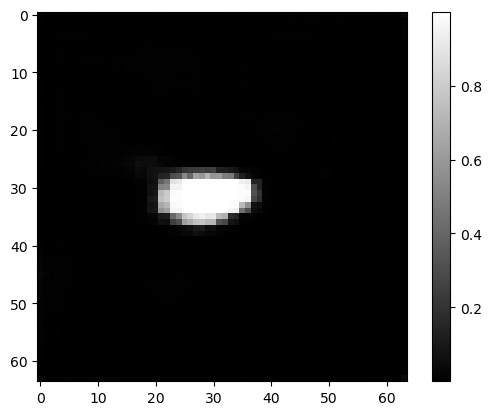

array([[0.02492263, 0.00364139, 0.0054848 , ..., 0.00751497, 0.00789797,
        0.04171994],
       [0.00596606, 0.00041149, 0.00066599, ..., 0.00048328, 0.00069585,
        0.01039499],
       [0.00394898, 0.0004332 , 0.00090427, ..., 0.0007729 , 0.00065497,
        0.00592848],
       ...,
       [0.00630709, 0.00072145, 0.00057944, ..., 0.00012093, 0.00012907,
        0.00445603],
       [0.00375687, 0.00055129, 0.00082413, ..., 0.00023856, 0.0001811 ,
        0.0045702 ],
       [0.02657243, 0.00396287, 0.00530959, ..., 0.00313959, 0.00306345,
        0.03822954]], dtype=float32)

In [ ]:
img, lab = next(iter(train_loader))
pred = generator(img.to(device))


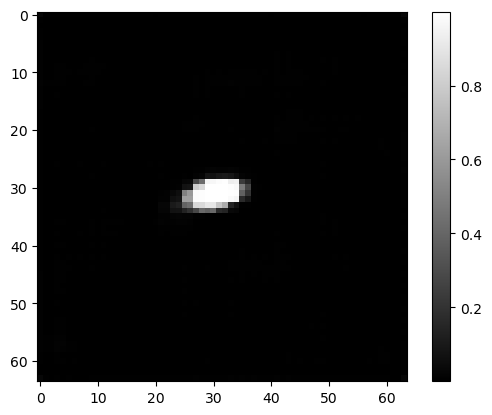

In [22]:
tensor_np = pred[1][0].detach().cpu().numpy()
#tensor_np = pred[22][0]

#tensor_np = (tensor_np > 0.5).astype(int)
plt.imshow(tensor_np, cmap='gray')
plt.colorbar()
plt.show()

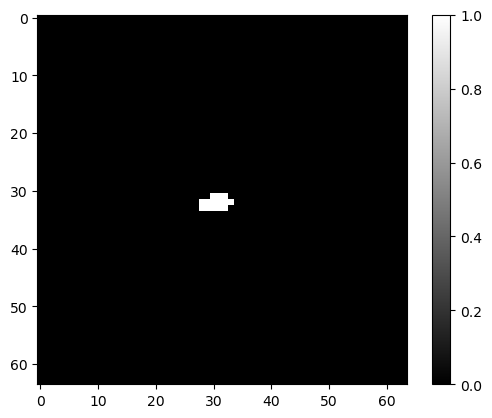

In [23]:
tensor_np = lab[1][0].detach().cpu().numpy()

plt.imshow(tensor_np, cmap='gray')
plt.colorbar()
plt.show()

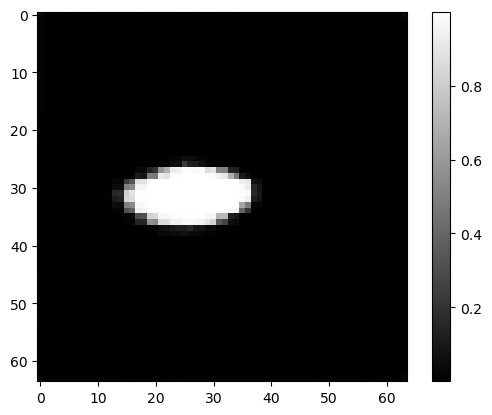

In [26]:
tensor_np = pred[11][0].detach().cpu().numpy()
#tensor_np = pred[22][0]

#tensor_np = (tensor_np > 0.5).astype(int)
plt.imshow(tensor_np, cmap='gray')
plt.colorbar()
plt.show()

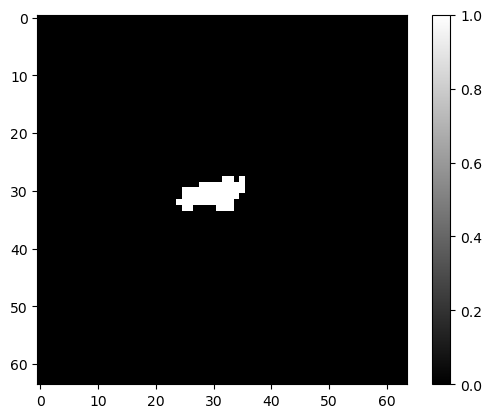

In [27]:
tensor_np = lab[11][0].detach().cpu().numpy()

plt.imshow(tensor_np, cmap='gray')
plt.colorbar()
plt.show()

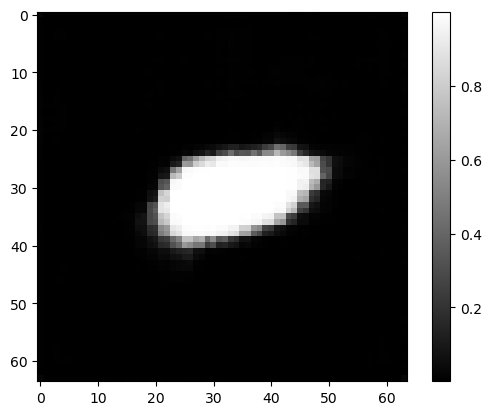

In [30]:
tensor_np = pred[13][0].detach().cpu().numpy()
#tensor_np = pred[22][0]

#tensor_np = (tensor_np > 0.5).astype(int)
plt.imshow(tensor_np, cmap='gray')
plt.colorbar()
plt.show()

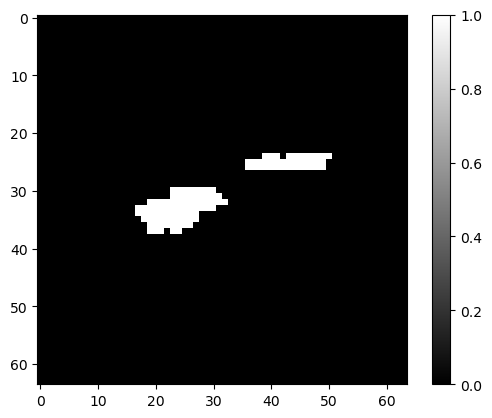

In [31]:
tensor_np = lab[13][0].detach().cpu().numpy()

plt.imshow(tensor_np, cmap='gray')
plt.colorbar()
plt.show()

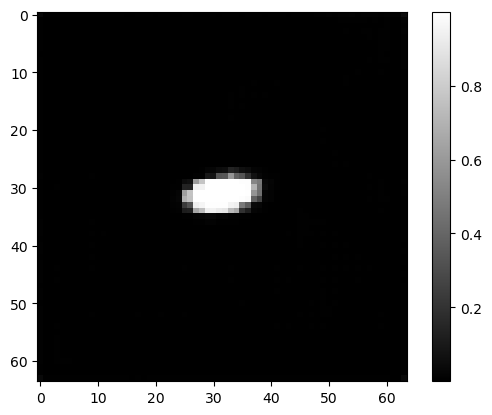

In [32]:
tensor_np = pred[14][0].detach().cpu().numpy()
#tensor_np = pred[22][0]

#tensor_np = (tensor_np > 0.5).astype(int)
plt.imshow(tensor_np, cmap='gray')
plt.colorbar()
plt.show()

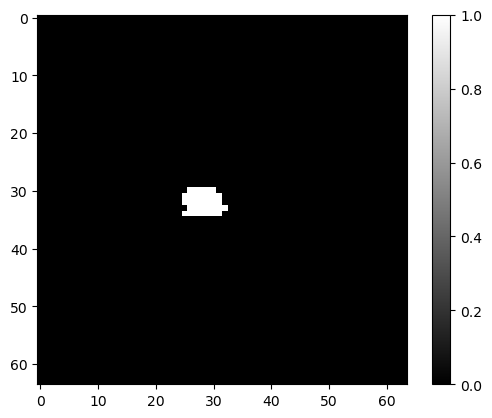

In [33]:
tensor_np = lab[14][0].detach().cpu().numpy()

plt.imshow(tensor_np, cmap='gray')
plt.colorbar()
plt.show()

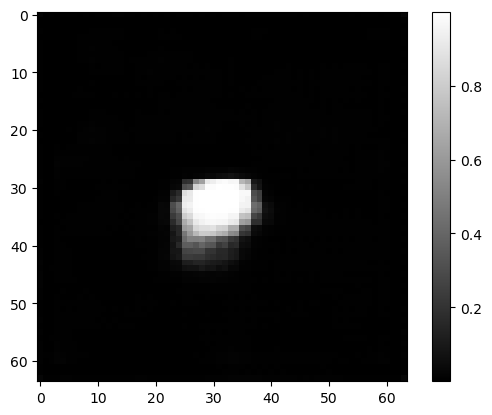

In [34]:
tensor_np = pred[15][0].detach().cpu().numpy()
#tensor_np = pred[22][0]

#tensor_np = (tensor_np > 0.5).astype(int)
plt.imshow(tensor_np, cmap='gray')
plt.colorbar()
plt.show()